# Import Statements

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

---

In [156]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

# Poly Tests

In [157]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [158]:
def poly_ridge_model(degree, alpha):
    X_poly_train = PolynomialFeatures(degree = degree).fit_transform(X_train)
    lin_reg_Poly = Ridge(alpha = alpha, normalize = True, solver = 'lsqr')
    lin_reg_Poly.fit(X_poly_train, y_train)
    
    return lin_reg_Poly

In [171]:
def calc_errors(degree_range, alpha_range):
    degree_length = len(degree_range)
    alpha_length = len(alpha_range)

    errors_arr = np.empty((degree_length, alpha_length))
    for i, degree in enumerate(degree_range):
        for j, alpha in enumerate(alpha_range):
            degree = int(degree)
            X_poly_val =  PolynomialFeatures(degree = degree).fit_transform(X_val)
            errors_arr[i][j] = mean_squared_error(poly_ridge_model(degree, alpha).predict(X_poly_val), y_val)
    
    errors = pd.DataFrame(errors_arr, columns = alpha_range, index = degree_range)

    return errors.sort_index(ascending=False)

In [160]:
def split_data(X, y):
    # Do a 50-50 split first
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=34)

    # Now split X_test to achive 50-20-30 split
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=(0.2/0.5),random_state=34)

    for name, data in {'train': X_train, 'validation': X_val, 'test': X_test}.items():
        print("""{}
        {} entries
        ~{:.2f}% of total data

        """.format(name, len(data), len(data)/len(X)))
        
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [161]:
def evaluate_model(model):
    mse = mean_squared_error(model.predict(X_test), y_test)
    mae = mean_absolute_error(model.predict(X_test), y_test)
    r2 = r2_score(model.predict(X_test), y_test)

    print("""Evaluation of model

    Mean-Squared-Error:             {:8.4f}
    Mean-Absolute-Error:            {:8.4f}
    
    Coefficient of determination:   {:8.4f} %
    """.format(mse, mae, r2*100))

## Marburg

We start by preparing the dataframe.  
First we resample the given data hourly.  
Then we extract some time related features from the datetime index and merge the resulting dataframe witht the weather data.

In [15]:
# peak demand
ma = pd.DataFrame(marburg.resample('H').count()["day"])
ma.rename(columns={'day': 'demand'}, inplace=True)

ma['dayofyear'] = ma.index.map(lambda datetime : datetime.dayofyear)
ma['week'] = ma.index.map(lambda datetime : datetime.week)
ma['weekday'] = ma.index.map(lambda datetime : datetime.weekday)
ma['is_weekday'] = ma['weekday'].map(lambda day : day < 5)
ma['hour'] = ma.index.map(lambda datetime : datetime.hour)

ma = ma.merge(marburg_weather, left_index=True, right_index=True)

In [99]:
ma

,demand,dayofyear,week,weekday,is_weekday,hour,temperature,precipitation
datetime,,,,,,,,
2019-01-20 00:00:00,7,20,3,6,False,0,-7.9,0.0
2019-01-20 01:00:00,8,20,3,6,False,1,-8.3,0.0
2019-01-20 02:00:00,5,20,3,6,False,2,-8.7,0.0
2019-01-20 03:00:00,1,20,3,6,False,3,-8.9,0.0
2019-01-20 04:00:00,2,20,3,6,False,4,-8.7,0.0
...,...,...,...,...,...,...,...,...
2020-01-20 19:00:00,36,20,4,0,True,19,-1.5,0.0
2020-01-20 20:00:00,31,20,4,0,True,20,-1.7,0.0
2020-01-20 21:00:00,16,20,4,0,True,21,-2.3,0.0


In [100]:
X = ma[['temperature', 'hour', 'precipitation', 'dayofyear','is_weekday']].values
y = ma['demand'].values

In [94]:
X_train, X_val, X_test, y_train, y_val, y_test  = split_data(X,y)

train
        4392 entries
        ~0.50% of total data

        
validation
        1757 entries
        ~0.20% of total data

        
test
        2635 entries
        ~0.30% of total data

        


In [170]:
PolynomialFeatures(degree = 2).fit_transform(X_val)

array([[1.00000e+00, 3.03000e+01, 1.80000e+01, ..., 4.16160e+04,
        2.04000e+02, 1.00000e+00],
       [1.00000e+00, 5.80000e+00, 2.10000e+01, ..., 1.69000e+02,
        1.30000e+01, 1.00000e+00],
       [1.00000e+00, 4.10000e+00, 2.00000e+00, ..., 1.30321e+05,
        3.61000e+02, 1.00000e+00],
       ...,
       [1.00000e+00, 3.10000e+00, 2.30000e+01, ..., 1.29600e+05,
        3.60000e+02, 1.00000e+00],
       [1.00000e+00, 1.37000e+01, 7.00000e+00, ..., 5.38240e+04,
        2.32000e+02, 1.00000e+00],
       [1.00000e+00, 1.68000e+01, 1.20000e+01, ..., 3.57210e+04,
        1.89000e+02, 1.00000e+00]])

In [172]:
degree_range = np.linspace(2, 10, 10)
alpha_range = np.logspace(-5, -3, 10)

### LONG PROCESSING OPERATION ###
ma_errors_1 = calc_errors(degree_range, degree_range)

In [115]:
ma_vmin_1 = ma_errors_1.values.min()
ma_vmin_1

189.45272172689337

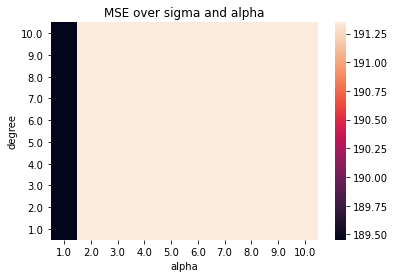

In [116]:
ax = sns.heatmap(ma_errors_1, vmin=ma_vmin_1, vmax=ma_vmin_1*1.01,
                 xticklabels=ma_errors_1.columns.values.round(4),
                 yticklabels=ma_errors_1.index.values.round(4))
ax.set_xlabel('alpha')
ax.set_ylabel('degree') 
ax.set_title('MSE over sigma and alpha')

plt.show()

In [131]:
poly_reg = PolynomialFeatures (degree = 5)
poly_reg.fit_transform(X_train)

array([[1.0000e+00, 9.1000e+00, 0.0000e+00, ..., 2.5600e+02, 1.6000e+01,
        1.0000e+00],
       [1.0000e+00, 3.1900e+01, 1.1000e+01, ..., 4.2025e+04, 2.0500e+02,
        1.0000e+00],
       [1.0000e+00, 6.0000e+00, 6.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 2.4300e+01, 1.3000e+01, ..., 2.2801e+04, 1.5100e+02,
        1.0000e+00],
       [1.0000e+00, 1.6100e+01, 1.7000e+01, ..., 7.2361e+04, 2.6900e+02,
        1.0000e+00],
       [1.0000e+00, 2.8800e+01, 1.0000e+01, ..., 5.6644e+04, 2.3800e+02,
        1.0000e+00]])

In [148]:
poly_reg = PolynomialFeatures (degree = 15)
X_poly_train = poly_reg.fit_transform(X_train)
lin_reg_Poly = Ridge(alpha = 0.1, normalize = True, solver = 'lsqr')
lin_reg_Poly.fit(X_poly_train, y_train)


X_poly_val = poly_reg.fit_transform(X_val)

mean_squared_error(lin_reg_Poly.predict(X_poly_val), y_val)

1704.9539936891474

In [165]:
PolynomialFeatures(degree = 3).fit_transform(X_val)

array([[1.00000e+00, 3.03000e+01, 1.80000e+01, ..., 4.16160e+04,
        2.04000e+02, 1.00000e+00],
       [1.00000e+00, 5.80000e+00, 2.10000e+01, ..., 1.69000e+02,
        1.30000e+01, 1.00000e+00],
       [1.00000e+00, 4.10000e+00, 2.00000e+00, ..., 1.30321e+05,
        3.61000e+02, 1.00000e+00],
       ...,
       [1.00000e+00, 3.10000e+00, 2.30000e+01, ..., 1.29600e+05,
        3.60000e+02, 1.00000e+00],
       [1.00000e+00, 1.37000e+01, 7.00000e+00, ..., 5.38240e+04,
        2.32000e+02, 1.00000e+00],
       [1.00000e+00, 1.68000e+01, 1.20000e+01, ..., 3.57210e+04,
        1.89000e+02, 1.00000e+00]])